# 19.5 Model Comparison Challenge

Here let's work on regression. Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Create a Jupyter notebook with your models. At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model. Submit a link to your notebook below.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import statsmodels.api as sm
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import normalize
%matplotlib inline
from sklearn import neighbors
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
wine = pd.read_csv(r'C:\Users\kylem\Desktop\Thinkful Data Science Projects\winequality-red.csv')

In [3]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [6]:
#missing value evaluation
total_missing = wine.isnull().sum().sort_values(ascending=False)
percent_missing = (wine.isnull().sum()/wine.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
quality,0,0.0
alcohol,0,0.0
sulphates,0,0.0
pH,0,0.0
density,0,0.0
total sulfur dioxide,0,0.0
free sulfur dioxide,0,0.0
chlorides,0,0.0
residual sugar,0,0.0
citric acid,0,0.0


In [7]:
#preview the top correlated variables to saleprice
np.abs(wine.corr().loc['quality']).sort_values(ascending=False)

quality                 1.000000
alcohol                 0.476166
volatile acidity        0.390558
sulphates               0.251397
citric acid             0.226373
total sulfur dioxide    0.185100
density                 0.174919
chlorides               0.128907
fixed acidity           0.124052
pH                      0.057731
free sulfur dioxide     0.050656
residual sugar          0.013732
Name: quality, dtype: float64

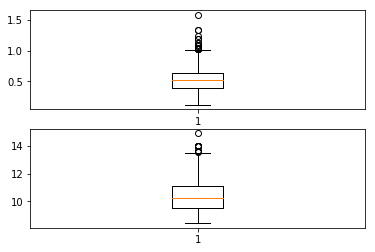

In [8]:
plt.subplot(2,1,1)
plt.boxplot(wine['volatile acidity'])

plt.subplot(2,1,2)
plt.boxplot(wine['alcohol'])

plt.show()

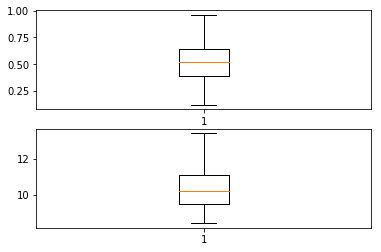

In [9]:
wine['winsorized_alcohol'] = winsorize(wine['alcohol'], (0, 0.01))
wine['winsorized_volatile_acidity'] = winsorize(wine['volatile acidity'], (0, 0.02))

plt.subplot(2,1,1)
plt.boxplot(wine['winsorized_volatile_acidity'])

plt.subplot(2,1,2)
plt.boxplot(wine['winsorized_alcohol'])

plt.show()

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_wine = scaler.fit_transform(wine)

In [11]:
scaled_wine_df = pd.DataFrame(scaled_wine,columns=wine.columns)
scaled_wine_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,winsorized_alcohol,winsorized_volatile_acidity
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,-0.787823,-0.968433,1.015536
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,-0.787823,-0.588190,2.063589
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,-0.787823,-0.588190,1.364887
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,0.450848,-0.588190,-1.429921
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,-0.787823,-0.968433,1.015536
5,-0.528360,0.738418,-1.391472,-0.524166,-0.264960,-0.274931,-0.196679,0.558274,1.288643,-0.579207,-0.960246,-0.787823,-0.968433,0.782635
6,-0.241094,0.403229,-1.083370,-0.666062,-0.392483,-0.083669,0.381091,-0.183745,-0.072005,-1.169337,-0.960246,-0.787823,-0.968433,0.433284
7,-0.585813,0.682553,-1.391472,-0.949853,-0.477498,-0.083669,-0.774449,-1.137769,0.511130,-1.110324,-0.397043,1.689519,-0.398068,0.724410
8,-0.298547,0.291499,-1.288771,-0.382271,-0.307468,-0.657454,-0.865676,0.028261,0.316751,-0.520193,-0.866379,1.689519,-0.873372,0.316834
9,-0.470907,-0.155419,0.457144,2.526589,-0.349975,0.107592,1.688677,0.558274,0.251958,0.837107,0.072294,-0.787823,0.077236,-0.148968


In [14]:
np.abs(scaled_wine_df.corr().loc['quality']).sort_values(ascending=False)

quality                        1.000000
winsorized_alcohol             0.478738
alcohol                        0.476166
volatile acidity               0.390558
winsorized_volatile_acidity    0.386746
sulphates                      0.251397
citric acid                    0.226373
total sulfur dioxide           0.185100
density                        0.174919
chlorides                      0.128907
fixed acidity                  0.124052
pH                             0.057731
free sulfur dioxide            0.050656
residual sugar                 0.013732
Name: quality, dtype: float64

In [15]:
knn = neighbors.KNeighborsRegressor(n_neighbors=5)
Y = scaled_wine_df.quality
X = scaled_wine_df[['winsorized_alcohol', 'winsorized_volatile_acidity']]
knn.fit(X, Y)
Y_ = knn.predict(scaled_wine_df[['winsorized_alcohol', 'winsorized_volatile_acidity']])
# Set up our prediction line.
T = np.arange(0, 50, 0.1)[:, np.newaxis]

# Trailing underscores are a common convention for a prediction.
knn_w = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')
Y = scaled_wine_df.quality
X = scaled_wine_df[['winsorized_alcohol', 'winsorized_volatile_acidity']]
knn_w.fit(X, Y)
Y_ = knn_w.predict(scaled_wine_df[['winsorized_alcohol', 'winsorized_volatile_acidity']])

score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: 0.14 (+/- 0.16)
Weighted Accuracy: 0.03 (+/- 0.17)


In [70]:
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
Y = scaled_wine_df.quality
X = scaled_wine_df[['winsorized_alcohol', 'winsorized_volatile_acidity']]
knn.fit(X, Y)
Y_ = knn.predict(scaled_wine_df[['winsorized_alcohol', 'winsorized_volatile_acidity']])
# Set up our prediction line.
T = np.arange(0, 50, 0.1)[:, np.newaxis]

# Trailing underscores are a common convention for a prediction.
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
Y = scaled_wine_df.quality
X = scaled_wine_df[['winsorized_alcohol', 'winsorized_volatile_acidity']]
knn_w.fit(X, Y)
Y_ = knn_w.predict(scaled_wine_df[['winsorized_alcohol', 'winsorized_volatile_acidity']])

score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: 0.20 (+/- 0.14)
Weighted Accuracy: 0.07 (+/- 0.15)


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .2, random_state = 465)
print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

X = sm.add_constant(X)

results = sm.OLS(y_train, X_train).fit()

results.summary()

The number of observations in training set is 1279
The number of observations in test set is 320


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     299.1
Date:                Tue, 19 Nov 2019   Prob (F-statistic):          2.87e-107
Time:                        23:59:24   Log-Likelihood:                -1603.5
No. Observations:                1279   AIC:                             3211.
Df Residuals:                    1277   BIC:                             3221.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
winsorized_alcohol              0.4326      0.024     17.917      0.000       0.385       0.480
winsorized_volatile_acidity    -0.3075      0.024    -12.664      0.000      -0.355      -0.260
==============================================================================
Omnibus:                       18.555   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.998
Skew:                          -0.156   Prob(JB):                     2.26e-06
Kurtosis:                       3.625   Cond. No.                         1.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.31894304513654204
-----Test set statistics-----
R-squared of the model in test set is: 0.28181757071632096
Mean absolute error of the prediction is: 0.5910407231959846
Mean squared error of the prediction is: 0.5568849771015907
Root mean squared error of the prediction is: 0.7462472627096134
Mean absolute percentage error of the prediction is: 84.95608374795323


These models aren't the greatest but I think it has more to do with the dataset than anything else. If I had to choose a better model, I would select the OLS regression model. It at least gives us some insight into the variables, for example, volatile acidity being negatively correlated with our dependent variable. Overall, the OLS model seemed to perform better in this case. Although the R squared values of the training and test sets are low, the evaluation metrics actually look decent.   

I'm not sure what else could be done with the data to improve the models but I'm thinking that some more feature engineering could improve them. The target variable may need to be categorized between low quality and high quality. Maybe designating a score of 7 or higher would be a high quality wine while anything falling below that would be low quality. We could then use a KNN as a classifier.

In [ ]:
#create an interaction term, try combining a few variables to see if we get a better r squared